# node structure 

Ideas: 
1-use the category of the meal as key of the dictionary of the dataset
2- this will be used in coordination with state.meal
3- the dataset will have the following form 
	{
		category : {{object},{object2},{object3}}
	}

# Problems: 
1- we have to check for daily calories so that they're satisfied which translates to checking the calories every three levels which represents a day 

In [1]:
import queue
import math

import copy
from math import sin, cos, radians, atan2, sqrt

# here for the convenience: we chose to add a meal and a day data member.
# using this we can make the check for the daily constraints easier
# for instance for calories we'll just check if the meal is a dinner so that we know that we are at the end of the day and o check if the calories are ok for the day. which we will call a valid state: a valid state is a state that will be considered a worthy state to be expanded. if a state is not valid; we simply won't expand it. ( pruning)


# ------------------------------
# 1. Node Class Definition
# ------------------------------

class Node:

	def __init__(self, state, parent = None , meal='breakfast' , cost = 0 , day = 0, g=0, f=0):

		self.state= state        # Current meal plan state (7x3 matrix)
		self.day  = day
		self.cost = cost
		self.meal = meal           # Meal object (if applicable)this will signify what the current category of the state is, will be passed from parent to childre: parent: breakfast -> child: lunch 
								   # starts by the breakfast as default

		self.depth = 0 if parent is None else parent.depth + 1
		self.g = g                # Cumulative cost from start to this node
		self.f = f                # Evaluation cost (g + heuristic if applicable)

	def __hash__(self):
		if isinstance(self.state, list):
			state_tuple = tuple([tuple(row) for row in self.state])
			return hash(state_tuple)
		return hash(self.state)

	def __eq__(self, other):
		return isinstance(other, Node) and self.state == other.state

	def __gt__(self, other):
		return isinstance(other, Node) and self.f > other.f
	
	def __str__(self):
		
		for row in self.state:
			temp = list()
			for meal in row:
				print(meal['title'],end=10*' ')
			print()
		return ''


In [ ]:
# ------------------------------------------------------------------------------
# Candidate Class: Represents a potential solution state and its evaluation
# ------------------------------------------------------------------------------

class Candidate:
    """
    Represents a candidate solution in a local search context.
    """
    def __init__(self, state, value):
        self.state = state
        self.value = value

    def __repr__(self):
        state_repr = str(self.state)
        if len(state_repr) > 50:
            state_repr = state_repr[:47] + "..."
        value_repr = f"{self.value:.4f}" if isinstance(self.value, float) else str(self.value)
        return f"Candidate(state={state_repr}, value={value_repr})"
    
    def __lt__(self, other):
        return self.value < other.value

# class definition

In [3]:
import json
from copy import deepcopy


with open("FixBalanced.json", "r") as f:
	Dataset = json.load(f)

# ------------------------------
# 2. mealPlanning Class for Food Recommendation System
# ------------------------------

meal_to_num = {
	'breakfast' : 0 ,
	'lunch' : 1 ,
	'dinner': 2
}
num_to_meal = [ 'breakfast' , 'lunch' , 'dinner' ]


DAYS_IN_WEEK  = 7
MEELS_PER_DAY = 3

class mealPlanning:

	def __init__(self, initial_state, goal_state,allergies,dietType):

		self.initial_state = initial_state  # Empty meal plan (7x3 matrix)
		self.goal_state = goal_state        # Target meal plan with calorie and cost goals
		self.allergies  = allergies         # List of allergies (if any)
		self.diets = dietType

		# Constraints
		self.max_repetitions = 1  # Max times a dish can be repeated in a week

	def is_goal(self, current_state):
		#compatible with hill climbing 

		# note :
		# -----------------------------------
		# hard constraints considered here 
		#
		#  ( margin of error is considered )
		# a full grid 
		# cost of state < budget               
		# calories daily match for user input 
		# allergies + diet_type
		# ------------------------------------

		# we must check for the cost because it is global, also we must check if the grid is full
		full = all ( x is not None for row in current_state for x in row)
		if not full:
			return False
		
		# check cost + calories 
		calories_per_day , total_cost = self._calculate_plan_stats(current_state)

		if total_cost > self.goal_state['cost'] + self.goal_state['cost']*self.goal_state['cost_margin']:
			return False
		
		daily_calorie_target = self.goal_state['cal']
		if any( abs( x-daily_calorie_target ) >  self.goal_state['calories_margin'] * daily_calorie_target for x in calories_per_day ):
			return False
					
		# check allergies+diet_type conditions if met 
		for row in current_state:
			for meal in row:		
				if not ( all( allergy in meal['allergies'] for allergy in self.allergies) and all( diet in meal['diet_type'] for diet in self.diets) ):
					return False
		
		return True

	def _calculate_plan_stats(self, state):

		# return cost of the plan + array of calories for the days
		# used in goal checkin ( helper for goal checker )

		calories_per_day = list() # array of 7
		total_cost = 0
		
		for day in range(DAYS_IN_WEEK):

			temp_calories = 0 # calories for the current day 
			for meal in range(MEELS_PER_DAY):

				dish = state[day][meal]
				if dish is not None:
					temp_calories += dish['calories']
					total_cost += dish['cost']
				calories_per_day.append(temp_calories)
					
		return calories_per_day , total_cost

	def _calculate_plan_stats_formating(self, state):

		# return cost of the plan + array of calories for the days
		# used in goal checkin ( helper for goal checker )

		calories_per_day = list() # array of 7
		cost_per_day     = list() # array of 7
		total_cost = 0

		nutritionalBreakdown = dict()
		
		for day in range(DAYS_IN_WEEK):

			temp_calories = 0 # calories for the current day 
			temp_cost     = 0
			for meal in range(MEELS_PER_DAY):

				dish = state[day][meal]
				if dish is not None:
					temp_calories += dish['calories']
					temp_cost  += dish['cost']
					total_cost += dish['cost']
				calories_per_day.append(temp_calories)
				cost_per_day.append(temp_cost)
					
		return calories_per_day  , cost_per_day ,  total_cost

	def get_valid_actions(self, current_node):

		# we can use sets for optimization, then just do the difference
		# find the category of the meal (i.e breakfast ..Etc)

		# checking only hard constraints as mentioned in goal check function
		meal_idx = meal_to_num[current_node.meal]
		valid_meals = []
		
		for meal in Dataset[current_node.meal]:

			# check for cost 
			cost_condition = self.goal_state['cost'] + self.goal_state['cost']*self.goal_state['cost_margin']
			valid_cost = meal['cost'] + current_node.cost <= cost_condition
			if not valid_cost:
				continue
			
			# check how many times this meal has been repeted 
			count_repetitions = 0
			for i in range( 0 , current_node.day ):
				if meal['title'] == current_node.state[i][meal_idx]['title']:
					count_repetitions+=1
			if count_repetitions >= self.max_repetitions:
				continue
			
			# check allergies and diet_type conditions
			if not ( all( allergy in meal['allergies'] for allergy in self.allergies) and all( diet in meal['diet_type'] for diet in self.diets) ):
				continue
		
			# if it is dinner check for the day condition for calories 
			# daily_goal <<< or <<< daily_goal will be rejected
			if meal_idx == 2 and not self.is_valid_meal(meal, current_node.state[current_node.day]) :
				continue

			# passed all test => valid meal
			valid_meals.append(meal)

		return valid_meals
	
	def is_valid_meal(self, meal, DayMeals):
		
		# Check if the meal is valid based on nutritional balance
		# Replace this with your own nutritional balance check logic

		calories = sum(meal['calories'] for meal in DayMeals if meal is not None) + meal['calories']

		daily_calorie_target = self.goal_state['cal']
		calorie_margin = daily_calorie_target * self.goal_state['calories_margin']

		calories_valid = abs(calories - daily_calorie_target) <= calorie_margin

		# fats and other nutritionals maybe considered soft uncritical constraints 
		# should be imeplemented in the cost and heuristic 
		'''
			proteins = sum(meal['proteins'] for meal in DayMeals if meal is not None) + meal['proteins']
			fats     = sum(meal['fats'] for meal in DayMeals if meal is not None) + meal['fats']
			carbs    = sum(meal['carbs'] for meal in DayMeals if meal is not None) + meal['carbs']
			rating   = (sum(meal['rating'] for meal in DayMeals if meal is not None) + meal['rating'] ) /3
			daily_protein_target = self.goal_state.get('prot', 75)
			daily_fats_target    = self.goal_state.get('fat', 70)
			daily_carbs_target   = self.goal_state.get('carb', 150)
			avg_rating 			 = self.goal_state.get('rating', 3)

			protein_margin = daily_protein_target * self.goal_state['proteins_margin']
			fat_margin     = daily_fats_target    * self.goal_state['fats_margin']
			carb_margin    = daily_carbs_target   * self.goal_state['carbs_margin']
			avg_rating     = self.goal_state['avg_rating']

			protein_valid  = abs(proteins - daily_protein_target) <= protein_margin
			fat_valid      = abs(fats - daily_fats_target) <= fat_margin
			carb_valid     = abs(carbs - daily_carbs_target) <= carb_margin
			del_valid 	   = rating >= avg_rating

			return calories_valid and protein_valid and fat_valid and carb_valid and del_valid
		'''

		return calories_valid
			
	def expand_node(self, node, A_search=False , ucs_search=False):
		state = node.state

		# Find valid actions for this state
		valid_meals = self.get_valid_actions(node)

		# meal type
		day_idx  = node.day
		child_nodes = []

		# the grid is full
		if ( day_idx >= DAYS_IN_WEEK ):
			return []

		# breakfast : 0 , lunch : 1 , dinner : 2  
		meal_idx = meal_to_num[node.meal]
		for meal in valid_meals:

			child_state =  deepcopy(state)
			child_state[day_idx][meal_idx] = meal

			# adding dinner => move to the next day
			new_day   = node.day + 1 if meal_idx == 2 else node.day
			# meal_indx + 1 map to keywords breakfast lunch dinner  
			next_meal = num_to_meal[ ( meal_idx+1)%3 ]

			child_g , child_f = 0 , 0

			if ucs_search :
				child_g = self.ucs_search_meal_cost(meal,meal_idx)
				child_f = child_g 

			elif A_search :
				# this is calling path cost of A* + heuristic
				pass

			# else ...
			# will calculate nothing since this is DFS

			child = Node( state=child_state , parent=node , meal=next_meal , day=new_day , cost=node.cost+meal['cost'] , f=child_f , g=child_g )
			child_nodes.append(child)
			
			
			# for the ones responsible for UCS and A* to figure out    
		return child_nodes
	


	def ucs_search_meal_cost(self, dish , meal_indx):
		
		# NOTE the values here arent tested yet ( possible changes after testing )
		# ------------------------------------------------------------------------

		# if the goal is to have 100 protein in the day 
		# breakfast should be 25grams , lunch 40grams , dinner 35grams
		MEAL_TO_IDEAL_PERCENTAGE = [ 0.25 , 0.40 , 0.35 ]
		# dummy values for the global wheights for UCS path cost function
		WEIGHT_OF_COST = 0.4
		WEIGHT_OF_NUTRITIONS = 0.8
		WEIGHT_OF_DELICIOUSNESS = 0.01
		# --------------------------------------------------------------------

		# 100 protein in day => for breakfast 100 proteins * NutriontsIdeal
		NutriontsIdealFactor  = MEAL_TO_IDEAL_PERCENTAGE[ meal_indx ]

		protein_deficit  = abs ( dish['proteins']-  self.goal_state.get('prot', 75)  * NutriontsIdealFactor ) / ( self.goal_state.get('prot', 75)  * NutriontsIdealFactor )
		fat_deficit      = abs ( dish['fats']    -  self.goal_state.get('fats', 75)  * NutriontsIdealFactor ) / ( self.goal_state.get('fats', 75)  * NutriontsIdealFactor )
		carbs_deficit    = abs ( dish['carbs']   -  self.goal_state.get('carbs', 75) * NutriontsIdealFactor ) / ( self.goal_state.get('carbs', 75) * NutriontsIdealFactor )

		# this one is debatable 👀👀
		calories_deficit = abs ( dish['calories'] - self.goal_state.get('cal', 75)   * NutriontsIdealFactor ) / ( self.goal_state.get('cal', 75)   * NutriontsIdealFactor )

		# -------------
		#	get the importance form the slider 
		#   proteins > carbs > fat ( example )
		# -------------

		Protein_w = 0.2
		Fat_w     = 0.3 
		Carbs_w   = 0.4
		Calories_w= 0.2
				
		return dish["cost"] * WEIGHT_OF_COST + ( protein_deficit*Protein_w + fat_deficit*Fat_w + Carbs_w*carbs_deficit + calories_deficit*Calories_w ) * WEIGHT_OF_NUTRITIONS + ( 1 - dish['rating']/5 ) * WEIGHT_OF_DELICIOUSNESS

	def get_crow_flies_distance(self, coordinates, goal_coordinates):
		# For food recommendation, this could be nutritional distance
		# More sophisticated implementations might use a multi-dimensional distance metric
		
		# Using Euclidean distance for simplicity
		squared_diff_sum = 0
		for i in range(len(coordinates)):
			squared_diff_sum += (coordinates[i] - goal_coordinates[i]) ** 2
			
		return math.sqrt(squared_diff_sum)

	
	def print_node(self, node):
		if node.action is not None:
			print("Action:", node.action, "| Depth:", node.depth)
			dish_info = self.state_transition_model[node.action]
			print(f"Added dish: {dish_info['name']}, Calories: {dish_info['calories']}, Cost: {dish_info['cost']}")
		
		# Print the meal plan
		if node.state is not None:
			print("\nCurrent Meal Plan:")
			days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
			meals = ["Breakfast", "Lunch", "Dinner"]
			
			for day_idx, day in enumerate(days):
				print(f"\n{day}:")
				for meal_idx, meal in enumerate(meals):
					dish_id = node.state[day_idx][meal_idx]
					if dish_id is not None:
						dish_info = self.state_transition_model[dish_id]
						print(f"  {meal}: {dish_info['name']} ({dish_info['calories']} cal, ${dish_info['cost']})")
					else:
						print(f"  {meal}: ---")

	def evaluate(self, position):
		'''
			the objective function : evaluate(node)
			goal = minimize the objective function
			it takes a meal plan and gives a penalty score; the lower, the better
		'''
		calorie_penalty = 0
		allergies_penalty = 0
		diet_penalty = 0
		macros_penalty = 0
		
		# Get the calories per day, cost per day, and total cost
		calories_per_day, cost_per_day, total_cost = self._calculate_plan_stats_formating(position)

		target_calories = self.goal_state['cal']  # Target calories per day
		calories_margin = self.goal_state['calories_margin']  # Acceptable margin
		protein_margin  = self.goal_state['prot_margin']
		carbs_margin = self.goal_state['carbs_margin']
		fats_margin = self.goal_state['fats_margin']
		margins = {
			'carbs': carbs_margin,
			'fats': fats_margin,
			'protein': protein_margin
		}

		total_macros = {
			'carbs': 0,
			'fats': 0,
			'protein': 0
		}

		for day in range(DAYS_IN_WEEK):
			for meal in range(3):
				dish = position[day][meal]
				if dish is not None:
					total_macros['carbs'] += dish.get('carbs', 0)
					total_macros['fats'] += dish.get('fats', 0)
					total_macros['protein'] += dish.get('protein', 0)


		# target_ptotein = self.goal_state['']

		# Evaluate calorie penalty for each day
		for daily_calories in calories_per_day:
			if abs(daily_calories - target_calories) > calories_margin:
				calorie_penalty += abs(daily_calories - target_calories) - calories_margin  # Extra deviation from target

		# Evaluate cost penalty (for the whole week)
		target_cost = self.goal_state['cost']  # Target cost for the week
		cost_margin = self.goal_state['cost_margin']  # Acceptable margin
		budget = target_cost # + (target_cost * cost_margin)  # Total budget with margin
		target_macros = {
			'carbs': self.goal_state['carbs'],
			'fats': self.goal_state['fats'],
			'protein': self.goal_state['prot']
		}
		
		cost_penalty = max(0, total_cost - budget)  # If total cost exceeds the budget, apply penalty

		# Evaluate allergies and diet penalties for each meal
		for day in position:
			for meal in day:
				if meal is not None:
					# Allergy Penalty: If any allergy is in the meal, apply penalty
					if any(allergy in meal['allergies'] for allergy in self.allergies):
						allergies_penalty += 10  # Fixed penalty per meal with allergy
					
					# Diet Penalty: If meal does not match required diet, apply penalty
					if not all(diet in meal['diet_type'] for diet in self.diets):
						diet_penalty += 1  # Fixed penalty for each diet mismatch

		for macro in ['carbs', 'fats', 'protein']:
			deviation = abs(total_macros[macro] - target_macros[macro])
			if deviation > margins[macro]:
				macros_penalty += (deviation - margins[macro]) * 0.4  # Small penalty weight (adjustable)

		# Return the total penalty score
		return calorie_penalty + cost_penalty + allergies_penalty + diet_penalty + macros_penalty
		

	def generate_neighbors(self, position, meal_idx):

		"""
        Generate neighboring nodes by swapping meals in the same meal category
        (breakfasts with breakfasts, lunches with lunches, etc.) across different days.
        """

		neighbors = []
		n_days = len(position)

		for i in range(n_days - 1):
			for j in range(i + 1, n_days):
				if position[i][meal_idx] is None or position[j][meal_idx] is None:
					continue

				# Create a deep copy of the current state and swap the meals
				new_state = copy.deepcopy(position)
				new_state[i][meal_idx], new_state[j][meal_idx] = new_state[j][meal_idx], new_state[i][meal_idx]

				# NEW: check each day in new_state for duplicate meal titles
				invalid = False
				for day in new_state:
					titles = [meal['title'] for meal in day]
					if len(set(titles)) < 3:  # i.e., some titles are repeated
						invalid = True
						break
					
					if invalid:
						continue  # skip this neighbor

				# Valid neighbor
				new_value = self.evaluate(new_state)
				neighbors.append(Candidate(new_state, new_value))

		return neighbors


'''
def is_valid_meal(self, meal, DayMeals):
	# Calculate total nutrients for the day with the new meal
	calories = sum(meal['calories'] for meal in DayMeals if meal is not None) + meal['calories']
	proteins = sum(meal['proteins'] for meal in DayMeals if meal is not None) + meal['proteins']
	fats = sum(meal['fats'] for meal in DayMeals if meal is not None) + meal['fats']
	carbs = sum(meal['carbs'] for meal in DayMeals if meal is not None) + meal['carbs']
	
	# Define reasonable ranges for daily nutrition
	# These could be user inputs or calculated based on goal state
	daily_calorie_target = self.goal_state.get('daily_calories', 2000)  # Default 2000 calories
	
	# Calculate acceptable ranges (typically 10-20% deviation is acceptable)
	calorie_margin = daily_calorie_target * 0.15  # 15% margin
	
	# Macro distribution targets (percentages of total calories)
	protein_target_pct = self.goal_state.get('protein_pct', 0.25)  # 25% of calories from protein
	fat_target_pct = self.goal_state.get('fat_pct', 0.30)  # 30% of calories from fat
	carb_target_pct = self.goal_state.get('carb_pct', 0.45)  # 45% of calories from carbs
	
	# Convert percentages to grams
	# Protein and carbs: 4 calories per gram, fat: 9 calories per gram
	protein_target_g = (daily_calorie_target * protein_target_pct) / 4
	fat_target_g = (daily_calorie_target * fat_target_pct) / 9
	carb_target_g = (daily_calorie_target * carb_target_pct) / 4
	
	# Define acceptable margins for macronutrients (20% deviation)
	protein_margin = protein_target_g * 0.20
	fat_margin = fat_target_g * 0.20
	carb_margin = carb_target_g * 0.20
	
	# Check if values are within acceptable ranges
	calories_valid = abs(calories - daily_calorie_target) <= calorie_margin
	protein_valid = abs(proteins - protein_target_g) <= protein_margin
	fat_valid = abs(fats - fat_target_g) <= fat_margin
	carb_valid = abs(carbs - carb_target_g) <= carb_margin
	
	# If we're checking dinner (the last meal of the day), be strict about totals
	# For breakfast and lunch, we should be more lenient since other meals will follow
	if len([m for m in DayMeals if m is not None]) == 2:  # This is dinner
		return calories_valid and protein_valid and fat_valid and carb_valid
	else:  # This is breakfast or lunch
		# For earlier meals, just make sure we're not exceeding daily targets
		return calories <= daily_calorie_target * 1.1 and proteins <= protein_target_g * 1.2

def init(self, initial_state, goal_state, allergies, dietType, 
			 calorie_margin_pct=0.15, protein_margin_pct=0.20, fat_margin_pct=0.20, carb_margin_pct=0.20):
	# Existing initialization code...
	self.calorie_margin_pct = calorie_margin_pct
	self.protein_margin_pct = protein_margin_pct 
	self.fat_margin_pct = fat_margin_pct
	self.carb_margin_pct = carb_margin_pct


def expand_node(self, node, use_cost=True, use_heuristic=False):
	# If the node represents a complete plan, don't expand further
	if node.day >= self.days_per_week:
		return []
	
	# Determine which meal type we're filling next
	meal_types = ["breakfast", "lunch", "dinner"]
	meal_type = meal_types[node.meal]
	
	# Get valid meals for this position
	valid_meals = self.get_valid_actions(node)
	
	# Generate child nodes
	children = []
	for meal in valid_meals:
		# Create a new state by copying the current state
		new_state = [row[:] for row in node.state]
		
		# Add the meal to the state
		new_state[node.day][node.meal] = meal
		
		# Determine the next position (day and meal)
		next_meal = (node.meal + 1) % 3
		next_day = node.day + 1 if next_meal == 0 else node.day
		
		# Calculate cost (could be financial cost, nutritional cost, etc.)
		# For now, using meal cost as the cost
		cost = node.cost + meal.cost
		
		# Calculate heuristic value if needed
		heuristic = 0
		if use_heuristic:
			# Remaining days * average daily cost as a simple heuristic
			remaining_days = self.days_per_week - next_day
			avg_daily_cost = self.goal_state.get('budget', 0) / self.days_per_week  
			heuristic = remaining_days * avg_daily_cost
			
			# Adjust heuristic based on how well we're meeting daily nutritional targets
			if node.meal == 2:  # After adding dinner, evaluate day completeness
				day_nutrients = self._calculate_day_nutrients(new_state[node.day])
				nutrient_balance = self._evaluate_nutrient_balance(day_nutrients)
				# Penalize days with poor nutritional balance
				heuristic += (1 - nutrient_balance) * 50  # Higher penalty for poor balance
		
		# Calculate f value (g + h)
		f_value = cost + heuristic if use_heuristic else cost
		
		# Create child node
		child = Node(
			state=new_state,
			day=next_day,
			meal=next_meal,
			cost=cost,
			f_value=f_value,
			parent=node,
			action=meal
		)
		
		children.append(child)
	
	return children



'''

# Example usage with a toy meal planning problem
def toy_test_meal_planning_problem():
	# Define a database of dishes with their properties
	
	# Define the initial state: empty 7x3 matrix (7 days, 3 meals per day)
	initial_state = [[None for _ in range(3)] for _ in range(7)]
	# to be taken from the user input
	
	# Define the goal state: target calories and cost for the week
	goal_state = {
		'cal': 8400,  # Average 1200 calories per day
		'calories_margin': 0.1,  # Acceptable margin of error
		'proteins_margin': 0.15,  # Acceptable margin of error
		'carbs_margin': 0.2,  # Acceptable margin of error
		'fats_margin': 0.1,  # Acceptable margin of error
		'cost': 140.00,  # Weekly food budget
		'cost_margin': 0.15,  # Acceptable margin of error
		'avg_rating': 3
		}
	
	# Create the problem instance
	meal_plan_problem = mealPlanning(
		initial_state=initial_state,
		goal_state=goal_state,
		allergies=[],
		dietType=[]
	)
	
	# Test the problem methods
	print("Testing meal planning problem:")
	
	# Test is_goal method
	print("\nTesting is_goal:")
	print("Is empty plan a goal?", meal_plan_problem.is_goal(initial_state))  # Should be False
	
	
	# Test expand_node
	print("\nTesting expand_node:")
	start_node = Node(state=initial_state, g=0)
	children = meal_plan_problem.expand_node(start_node)
	# print(f"Number of child nodes: {len(children)}")
	
	# # Test print_node
	# print("\nTesting print_node:")
	# meal_plan_problem.print_node(start_node)
	
	# if children:
		# print("\nSample child node:")
		# meal_plan_problem.print_node(children[0])
	

if __name__ == "__main__":
	print( "start dummy testing")
	# Run the toy test for meal planning
	toy_test_meal_planning_problem()

start dummy testing
Testing meal planning problem:

Testing is_goal:
Is empty plan a goal? False

Testing expand_node:


# **_hill_climbing(problem, selection_strategy="steepest")**
Performs local search using a specified strategy.

### problem: An object that implements:
- initial_state
- evaluate(state)
- generate_neighbors(state, meal_idx)
- selection_strategy (str): One of "steepest", "stochastic", or "first_choice"
" we chose steepest since it gives us the best neighbour"

### Returns:
- Candidate object representing the best local optimum found.

### Strategies:
- steepest: Picks the neighbor with the best (lowest) evaluation.
- stochastic: Randomly picks among neighbors that improve the solution.
- first_choice: Takes the first improving neighbor.

---

# **random_restart_hill_climbing(problem_instance, num_restarts=10000, base_strategy="steepest")**
Executes hill climbing multiple times with random initial states.

### Arguments:
- problem_instance: Your meal planning problem instance.
- num_restarts: How many times to restart with a new random state.
- base_strategy: The hill climbing strategy to use in each run.

### Returns:
- The best Candidate found over all restarts.

---

## Smart Meal Swapping:
Swapping meals **of the same category** across days improves balance and score.  
For example, if the user’s calorie goal is 1500/day:
- **Day 1**: Breakfast = 400, Lunch = 200, Dinner = 400  
- **Day 2**: Breakfast = 400, Lunch = 700, Dinner = 900  

Swapping lunches of the two days makes both days more calorie-balanced.  
This strategy improves evaluation and finds better candidates.

---

## Why Random Restart?

Hill climbing can get stuck in **plateaus** or **local maxima**.ithelps by:
- Exploring new regions of the state space  
- Increasing the chance of escaping poor local optima  
- Overcoming bad initial configurations

---

## Why Use the Steepest-Ascent Strategy?

- **First-Choice**: May stop early on suboptimal neighbors, especially when neighbors are numerous.
- **Stochastic**: Picks randomly among better neighbors — uncertain and potentially far from optimal.

In contrast, **Steepest-Ascent**:
- Evaluates all neighbors
- Picks the one with the best improvement
- Increases the chance of finding optimal configurations  
- Best aligns with user constraints and goals

---

## Hard Constraints :

To enforce strict user needs, we use **hard constraints** in the evaluation function and assign high penalties to violations.
- **Allergies :**  Assigned a **very high penalty (10)** to strongly discourage unsafe meals. 
- **Calories :**  Penalty added if calorie deviation exceeds margin.                      
- **Macros :** Minor penalty to differentiate optimal from average meal plans.         
- **Diet Type :** Small penalty for mismatches to encourage diet compliance.              
- **Cost :** Penalty only when exceeding the weekly budget.                          

---

## Penalty Breakdown

1. **Calorie Penalty**  
   - Applied if daily calories exceed the tolerance margin.  
   - Keeps meals near target calorie intake.

2. **Cost Penalty**  
   - Only applied when total cost exceeds the budget.  
   - Encourages economical planning.

3. **Allergy Penalty**  
   - Applied per meal containing allergens:  
     **Allergy Penalty = 10 × a**  
   - Ensures strict avoidance of allergenic ingredients.

4. **Diet Penalty**  
   - Applied per meal not matching diet:  
     **Diet Penalty = 1 × d**  
   - Promotes dietary preference adherence.

5. **Macros Penalty**  
   - Small weighted deviation penalty:  
     e.g., **0.4 per unit deviation**

---


In [4]:
import random

def _hill_climbing(problem, selection_strategy="steepest"):
    """
    Performs hill climbing local search based on the given selection strategy.

    Input:
      - problem: An instance of a problem class that provides:
          * initial_state: the starting state
          * evaluate(state): a function to compute the state’s score
          * generate_neighbors(state): a function that returns a list of neighboring states
      - selection_strategy: A string indicating the strategy to use. Valid options are:
          "steepest"   - choose the neighbor with the best (lowest) evaluation.
          "stochastic" - randomly choose among the neighbors that improve the solution.
          "first_choice" - take the first neighbor found that improves the evaluation.

    Output:
      - Returns a Candidate (object with state and its evaluation value) representing a local optimum found.
    """
    current_state = problem.initial_state[:]  
    # print(problem.initial_state)
    current_value = problem.evaluate(current_state)
    # print(current_value)
    current_candidate = Candidate(current_state, current_value)
    
    while True:
        neighbor_candidates = []
        for meal_idx in range(3):  # 0 for breakfast, 1 for lunch, 2 for dinner
            neighbor_candidates += problem.generate_neighbors(current_state, meal_idx)
            
        #neighbor_candidates = problem.generate_neighbors(current_state)
        if not neighbor_candidates:
            break

        #neighbor_candidates = [Candidate(state, problem.evaluate(state)) for state in neighbors]

        if selection_strategy == "steepest":
            next_candidate = min(neighbor_candidates, key=lambda c: c.value, default=None)
            if next_candidate and next_candidate.value < current_value:
                current_candidate = next_candidate
                current_state = current_candidate.state
                current_value = current_candidate.value
            else:
                break  
        elif selection_strategy == "stochastic":
           
            better_neighbors = [c for c in neighbor_candidates if c.value < current_value]
            if better_neighbors:
                current_candidate = random.choice(better_neighbors)
                current_state = current_candidate.state
                current_value = current_candidate.value
            else:
                break  
        elif selection_strategy == "first_choice":
            
            found_better = False
            for candidate in neighbor_candidates:
                if candidate.value < current_value:
                    current_candidate = candidate
                    current_state = current_candidate.state
                    current_value = current_candidate.value
                    found_better = True
                    break
            if not found_better:
                break  
        else:
            raise ValueError(f"Unknown selection strategy: {selection_strategy}")

    return current_candidate


def generate_random_initial_state():

    DAYS_IN_WEEK = 7
    state = []
    used_meals = []

    for _ in range(DAYS_IN_WEEK):
        while True:
            breakfast = random.choice(Dataset['breakfast'])
            lunch = random.choice(Dataset['lunch'])
            dinner = random.choice(Dataset['dinner'])

            if (
                breakfast['title'] not in used_meals and
                lunch['title'] not in used_meals and
                dinner['title'] not in used_meals
            ):
                used_meals.append(breakfast['title'])
                used_meals.append(lunch['title'])
                used_meals.append(dinner['title'])
                break
        day_meals = [breakfast, lunch, dinner]
        state.append(day_meals)

    return state

# Random restart hill climbing : 

In [5]:
def random_restart_hill_climbing(problem_instance, num_restarts=10000, base_strategy="steepest"):
    """
    Performs hill climbing multiple times with random restarts to overcome local optima.

    Input:
      - problem_instance: an instance of a problem (TSPProblem or EightQueensProblem) that will be used to generate new initial states.
      - num_restarts: an integer, the number of random restarts to perform.
      - base_strategy: a string indicating the hill climbing strategy ("steepest", "stochastic", "first_choice") to use for each run.

    Output:
      - Returns the best Candidate (with the lowest evaluation value) found across all restarts.
    """
    best_candidate_overall = None  # This will hold the best solution found across all restarts

    # Repeat for the specified number of restarts
    for i in range(num_restarts):
        # Step 1: Perform a random restart by creating a new problem instance with a random initial state
        problem_instance.initial_state = generate_random_initial_state()  # Assuming a method to generate random states
        
        # Step 2: Perform hill climbing on the new problem instance using the selected strategy
        candidate_this_restart = _hill_climbing(problem_instance, selection_strategy=base_strategy)

        # Step 3: Update the best candidate if this restart resulted in a better solution
        if best_candidate_overall is None or candidate_this_restart.value < best_candidate_overall.value:
            best_candidate_overall = candidate_this_restart

    # Step 4: After all restarts, return the best candidate found
    # print(type(best_candidate_overall.state))
    # for i in range(len(best_candidate_overall.state)):
    #     print(best_candidate_overall.state[i])
    return best_candidate_overall

start dummy testing
Testing search for meal planning problem:


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_18840\2759716272.py:244: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


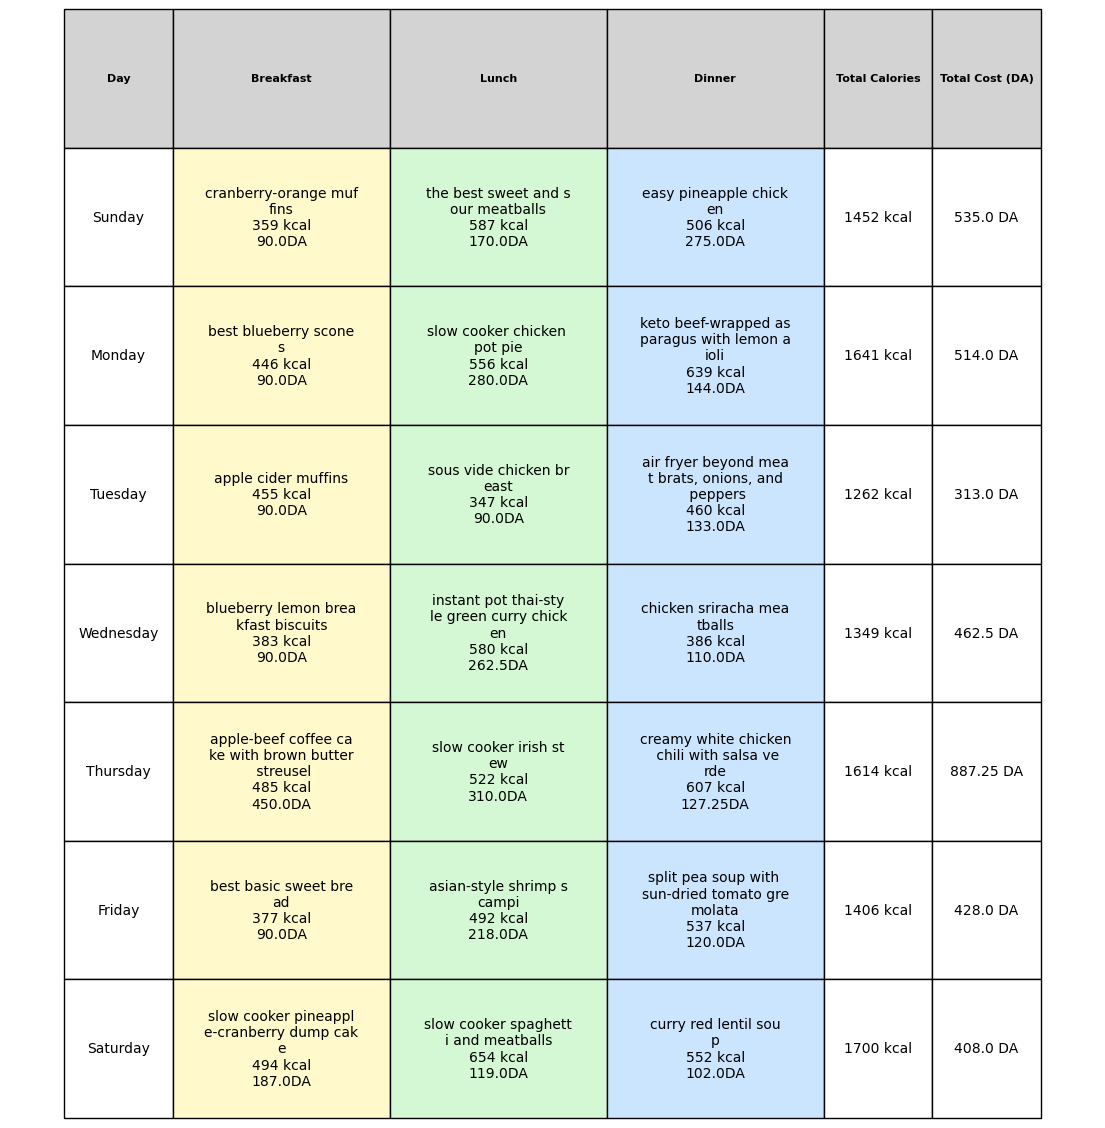


Day: Sunday
1452
535.0
  - Name: cranberry-orange muffins
    Cost: 90.0DA
    Calories: 359
    Macros: Protein=17.4, Carbs=56.5, Fats=14.0
    Diet Type: ['vegetarian', 'gluten-free']
    Allergies: ['fish-free', 'peanut-free']
  - Name: the best sweet and sour meatballs
    Cost: 170.0DA
    Calories: 587
    Macros: Protein=29.1, Carbs=71.6, Fats=20.5
    Diet Type: ['', 'dairy-free']
    Allergies: ['fish-free', 'peanut-free']
  - Name: easy pineapple chicken
    Cost: 275.0DA
    Calories: 506
    Macros: Protein=27.8, Carbs=42.6, Fats=22.3
    Diet Type: ['', 'dairy-free']
    Allergies: ['wheat-free', 'fish-free', 'peanut-free']

Day: Monday
1641
514.0
  - Name: best blueberry scones
    Cost: 90.0DA
    Calories: 446
    Macros: Protein=15.7, Carbs=77.8, Fats=17.2
    Diet Type: ['vegetarian', 'gluten-free']
    Allergies: ['fish-free', 'peanut-free']
  - Name: slow cooker chicken pot pie
    Cost: 280.0DA
    Calories: 556
    Macros: Protein=44.1, Carbs=60.6, Fats=15.2
    

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# ------------------------------
# 3. General Search Class
# ------------------------------
class GeneralSearch:
	def __init__(self, problem):

		self.problem = problem
		self.A_search = False
		self.ucs_search = False

	def set_frontier(self, search_strategy="depth_first"):

		if search_strategy == "depth_first":

			frontier = queue.LifoQueue()

		elif search_strategy == "uniform_cost":

			frontier = queue.PriorityQueue()
			self.ucs_search = True

		elif search_strategy == "A*":

			frontier = queue.PriorityQueue()
			self.A_search = True

		else:
			# If an unsupported search strategy is provided, raise an error to alert the user.
			raise ValueError("Unsupported search strategy: " + str(search_strategy))

		return frontier

	def search(self, search_strategy="breadth_first", max_depth=float('inf')):
		if search_strategy == "hill_climbing":

			#self.problem.initial_state = generate_random_initial_state()
			#result_Candidate = _hill_climbing(self.problem, "steepest")
			result_Candidate = random_restart_hill_climbing(self.problem, 100, "steepest")
			return Node(result_Candidate.state)
		
		frontier = self.set_frontier(search_strategy)
		initial_node = Node(self.problem.initial_state)
		frontier.put(initial_node)

		while not frontier.empty():

			node = frontier.get()

			if self.problem.is_goal(node.state):
				return node
		

			if node.depth > max_depth:
				continue

			
			children = self.problem.expand_node(node,self.A_search,self.ucs_search)

			for child_node in children:
				frontier.put(child_node)


		return None  # Return None if no solution is found.


# takes a matrix and return the result as dummy_data format
def formating_result( state , problem ):

	Days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
	meal_Type = [ "Breakfast" , "Lunch" , "Dinner"]
	Calories_per_day , cost_per_day , Total_cost = problem._calculate_plan_stats_formating(state)

	response = dict()
	days = []

	for i in range(7):
		temp_day = dict()

		temp_day['day'] = Days[i]
		temp_day['totalCalories'] =  sum(meal['calories'] for meal in state[i])
		temp_day['totalCost'] = sum(meal['cost'] for meal in state[i])

		nutritionalBreakdown = dict()
		current_day_meals = state[i]

		# Calculate the macros for the day
		carbs = sum(meal['carbs'] for meal in current_day_meals)
		fats = sum(meal['fats'] for meal in current_day_meals)
		protein = sum(meal['proteins'] for meal in current_day_meals)

		nutritionalBreakdown["carbs"] = carbs
		nutritionalBreakdown["fats"] = fats
		nutritionalBreakdown["protein"] = protein

		temp_day['nutritionalBreakdown'] = nutritionalBreakdown

		meals = []  # Initialize the list of meals

		# Loop over all meals (Breakfast, Lunch, Dinner)
		for j in range(3):
			meal = dict()

			meal['id'] = j  # Assuming meal ID can be set as the index
			meal['type'] = meal_Type[j]
			meal['name'] = current_day_meals[j]['title'] if current_day_meals[j] else "No Meal"
			meal['description'] = current_day_meals[j]['title'] if current_day_meals[j] else "No Meal"
			meal['calories'] = current_day_meals[j]['calories'] if current_day_meals[j] else 0
			meal['rating'] = current_day_meals[j]['rating'] if current_day_meals[j] else 0
			meal['cost'] = str(current_day_meals[j]['cost']) + "DA" if current_day_meals[j] else "0DA"
			meal['tags'] = current_day_meals[j]["diet_type"] + current_day_meals[j]['allergies'] if current_day_meals[j] else []

			macros = dict()
			macros['protein'] = current_day_meals[j]['proteins'] if current_day_meals[j] else 0
			macros['carbs'] = current_day_meals[j]['carbs'] if current_day_meals[j] else 0
			macros['fats'] = current_day_meals[j]['fats'] if current_day_meals[j] else 0
			meal['macros'] = macros

			meals.append(meal)  # Add the current meal to the list of meals for the day

		temp_day['meals'] = meals  # Add the list of meals for this day to the day dictionary
		days.append(temp_day)

	response['days'] = days

	# User information
	user = dict()
	user['name'] = 'name'  # Assuming 'name' will be set dynamically
	user['dailyCalorieGoal'] = problem.goal_state['cal']
	response['user'] = user

	return response
	

def toy_test_search(strategy):
	# Define a database of dishes with their properties
	
	# Define the initial state: empty 7x3 matrix (7 days, 3 meals per day)
	initial_state = [[None for _ in range(3)] for _ in range(7)]
	# to be taken from the user input
	
	# Define the goal state: target calories and cost for the week
	goal_state = {
		'cal'  : 1900,
		'fats' : 35,
		'prot' : 75,
		'carbs': 75,
		'cost' : 2000,
		"calories_margin"  : 0.008,
		"prot_margin"  : 0.001,
		"carbs_margin"  : 0.001,
		"fats_margin"  : 0.001,
		"cost_margin"  : 0.001
	}
	
	# Create the problem instance
	meal_plan_problem = mealPlanning(
		initial_state=initial_state,
		goal_state=goal_state,
		allergies=[],
		dietType=['vegetarian']
	)
	
	# Test the problem methods
	print("Testing search for meal planning problem:")
	
	searching_object = GeneralSearch(meal_plan_problem)
	return formating_result(searching_object.search(strategy).state,meal_plan_problem)


if __name__ == "__main__":
	print( "start dummy testing")
	# Run the toy test for meal planning
	# print( toy_test_search("hill_climbing")['days'] )
	result = toy_test_search("hill_climbing")
	days = result['days']

	columns = ["Day", "Breakfast", "Lunch", "Dinner", "Total Calories", "Total Cost (DA)"]

	# Populating rows
	table_data = []
	for day in days:
		breakfast_name = '\n'.join([day['meals'][0]['name'][i:i+20] for i in range(0, len(day['meals'][0]['name']), 20)])
		lunch_name     = '\n'.join([day['meals'][1]['name'][i:i+20] for i in range(0, len(day['meals'][1]['name']), 20)])
		dinner_name    = '\n'.join([day['meals'][2]['name'][i:i+20] for i in range(0, len(day['meals'][2]['name']), 20)])

		breakfast = f"{breakfast_name}\n{day['meals'][0]['calories']} kcal\n{day['meals'][0]['cost']}"
		lunch     = f"{lunch_name}\n{day['meals'][1]['calories']} kcal\n{day['meals'][1]['cost']}"
		dinner    = f"{dinner_name}\n{day['meals'][2]['calories']} kcal\n{day['meals'][2]['cost']}"
		
		# breakfast = f"{day['meals'][0]['name']}\n{day['meals'][0]['calories']} kcal\n{day['meals'][0]['cost']}"
		# lunch = f"{day['meals'][1]['name']}\n{day['meals'][1]['calories']} kcal\n{day['meals'][1]['cost']}"
		# dinner = f"{day['meals'][2]['name']}\n{day['meals'][2]['calories']} kcal\n{day['meals'][2]['cost']}"
		
		row = [
			day['day'],
			breakfast,
			lunch,
			dinner,
			f"{day['totalCalories']} kcal",
			f"{day['totalCost']} DA"
		]
		table_data.append(row)

	# Create the table
	fig, ax = plt.subplots(figsize=(14, 6))
	ax.axis("off")

	# Display the table
	table = ax.table(
		cellText=table_data,
		colLabels=columns,
		loc="center",
		cellLoc='center',
		colWidths=[0.1, 0.2, 0.2, 0.2, 0.1, 0.1]
	)

	table.auto_set_font_size(False)
	table.set_fontsize(10)
	table.scale(1, 2.2)

	for key, cell in table.get_celld().items():
		cell.set_height(0.3)  # Try 0.3–0.5 for more space

	for (row, col), cell in table.get_celld().items():
		if row == 0:
			cell.set_text_props(weight='bold', fontsize=8)
			cell.set_facecolor("#d3d3d3")
		elif col == 1:
			cell.set_facecolor("#fff9cc")  # Breakfast - light yellow
		elif col == 2:
			cell.set_facecolor("#d4f7d4")  # Lunch - light green
		elif col == 3:
			cell.set_facecolor("#cce5ff")  # Dinner - light blue

	# # Bold headers
	# for (row, col), cell in table.get_celld().items():
	# 	if row == 0:
	# 		cell.set_text_props(weight='bold')

	#plt.title("Weekly Meal Plan Summary", fontsize=14, weight='bold')
	plt.tight_layout()
	plt.show()
	
	for day in result['days']:
		print(f"\nDay: {day['day']}")
		print(day['totalCalories'])
		print(day['totalCost'])
		for meal in day['meals']:
			print(f"  - Name: {meal['name']}")
			print(f"    Cost: {meal['cost']}")
			print(f"    Calories: {meal['calories']}")
			print(f"    Macros: Protein={meal['macros']['protein']}, Carbs={meal['macros']['carbs']}, Fats={meal['macros']['fats']}")
			print(f"    Diet Type: {meal['tags'][:len(meal['tags'])//2]}")  # diet_type
			print(f"    Allergies: {meal['tags'][len(meal['tags'])//2:]}")  # allergies
